## Reporte: Comparación de variables en poblaciones pediátricas y no pediátricas

Los archivos en esta carpeta permiten generar las ilustraciones y tablas asociados al reporte *Comparación de variables en poblaciones pediátricas y no pediátricas* realizado en el marco del proyecto FONDEF ID23I10423 
*Sistema informático en base a inteligencia artificial para predecir peak de hospitalizaciones pediátricas por causas respiratorias*.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

# Import required libraries
#import sklearn
import numpy as np
import matplotlib.pyplot as plt

# Dividing dataset into training and testing dataset and standarized the features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier

from sklearn.decomposition import PCA

In [2]:
periodo = 365
USE_CUMSUM = True

lista_agrupaciones6 = [[0], [1], [2], [3], [4], [5],
     [0,1], [0,2], [0,3], [0,4], [0,5], [1,2], [1,3], 
     [1,4], [1,5], [2,3],[2,4], [2,5],[3,4],[3,5],[4,5],
     [0,1,2], [0,1,3], [0,1,4], [0,1,5], [0,2,3], [0,2,4], [0,2,5],
     [0,3,4], [0,3,5], [0,4,5]]
lista_agrupaciones5 = [[0], [1], [2], [3], [4], [0,1], [0,2], [0,3], [0,4], [1,2], [1,3], [1,4],[2,3],[2,4],[3,4]]
lista_agrupaciones4 = [[0], [1], [2], [3], [0,1], [0,2], [0,3]]  
lista_agrupaciones3 = [[0], [1], [2]]



grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
lista_establecimientos = ["Hospital",  "SAPU","SAR", "SUR","CEAR"]
lista_establecimientos_legend = ["Hospital",  "SAPU","SAR", "SUR","CEAR"]
grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]

#Para el analisis PCA/SVM consideraremos dos tipos de analsis 

#for ind in [0,1,2]:  #pacientes pediatricos
#for ind in [3,4]:  #pacientes no pediatricos
filtro_grupo_etarios = [0,1,2,3,4]
lista_agrupaciones = lista_agrupaciones5
year_list_str = '(2022,2023)'


In [3]:
## TABLA 5 lista de las atenciones correspondiente a cada tipo de establecimiento durante el año 2023
duckdb.sql("""select distinct year(strptime(fecha, '%d/%m/%Y')) as year
, GLOSATIPOESTABLECIMIENTO 
, sum(Total) as atenciones
from datos_urgencia_consolidados.parquet
where  year(strptime(fecha, '%d/%m/%Y')) = 2023
group by year, GLOSATIPOESTABLECIMIENTO
order by year, GLOSATIPOESTABLECIMIENTO
""").show(max_rows = 100)
# CEAR: Exclusivos de Atención Respiratoria (CEAR). Pocos datos, sin información para todos los dias
# SUR: Servicio de Urgencia Rural. Pocos datos, sin información para todos los dias
# SAR: Servicio de Atención Primaria de Urgencias de Alta Resolución
# SAPU: Servicio de Atención Primaria de Urgencias

┌───────┬──────────────────────────┬────────────┐
│ year  │ GLOSATIPOESTABLECIMIENTO │ atenciones │
│ int64 │         varchar          │   int128   │
├───────┼──────────────────────────┼────────────┤
│  2023 │ CEAR                     │      57930 │
│  2023 │ Hospital                 │   26687660 │
│  2023 │ SAPU                     │   22775071 │
│  2023 │ SAR                      │   15132586 │
│  2023 │ SUR                      │    4336901 │
└───────┴──────────────────────────┴────────────┘



In [4]:
#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoDependencia
    , GLOSATIPOESTABLECIMIENTO as establecimiento
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and year(strptime(fecha, '%d/%m/%Y')) in  """ + year_list_str + """
and CodigoDependencia is not null
and GLOSATIPOESTABLECIMIENTO is not null
group by CodigoDependencia, GLOSATIPOESTABLECIMIENTO, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
""").df()

df2 = df2.sort_values(by=['CodigoDependencia','establecimiento','year','nrodia']).reset_index(drop = True)
df3 = pd.concat([df2[['CodigoDependencia','establecimiento',"year","nrodia","Menores_1"]].rename(columns={"Menores_1":"atenciones"}).assign(grupo_etario = "Menores_1"),
df2[['CodigoDependencia','establecimiento',"year","nrodia","De_1_a_4"]].rename(columns={"De_1_a_4":"atenciones"}).assign(grupo_etario = "De_1_a_4"),
df2[['CodigoDependencia','establecimiento',"year","nrodia","De_5_a_14"]].rename(columns={"De_5_a_14":"atenciones"}).assign(grupo_etario = "De_5_a_14"),
df2[['CodigoDependencia','establecimiento',"year","nrodia","De_15_a_64"]].rename(columns={"De_15_a_64":"atenciones"}).assign(grupo_etario = "De_15_a_64"),
df2[['CodigoDependencia','establecimiento',"year","nrodia","De_65_y_mas"]].rename(columns={"De_65_y_mas":"atenciones"}).assign(grupo_etario = "De_65_y_mas")
])


df2 = df3.sort_values(by=["year",'CodigoDependencia','establecimiento',"grupo_etario","nrodia"]).reset_index(drop=True)

In [5]:
#display(df2["establecimiento"].drop_duplicates())

In [6]:
# Hay entradas correspondientes a centros de salud rurales 
# en que no hay datos para todos los dias del año, por lo 
# cual trabajaremos bajo la suposicion que corresponden a 
# cero atenciones para aquellos días

lista_dias = [k+1 for k in range(periodo)]

groups = df2[['year','CodigoDependencia','establecimiento','grupo_etario']].drop_duplicates()
df_aux =df2.copy()
df_output_list = []
for (index, year, codigo_dependencia, establecimiento, grupo_edad) in groups.itertuples():
    indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'CodigoDependencia'] == codigo_dependencia) & (df_aux.loc[:,'establecimiento'] == establecimiento) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
    if sum(indicesToKeep)>0:
        if df_aux.loc[indicesToKeep,  'atenciones'].sum() >0:
            if sum(indicesToKeep) <365:
                df_fill_data = df_aux.loc[indicesToKeep, :].set_index("nrodia").reindex(lista_dias).reset_index()
                df_fill_data.loc[:,"year"] = year
                df_fill_data.loc[:,"CodigoDependencia"] = codigo_dependencia
                df_fill_data.loc[:,"establecimiento"] = establecimiento
                df_fill_data.loc[:,"grupo_etario"] = grupo_edad
                df_output_list.append(df_fill_data.fillna(0))
            else: 
                df_output_list.append(df_aux.loc[indicesToKeep, :])
        else:
            #Esto corresponde a que dicho grupo no contienen atenciones
            print("removemos caso: ",(year, codigo_dependencia, establecimiento, grupo_edad))

df_output = pd.concat(df_output_list).reset_index(drop = True)
df_output = df_output.sort_values(by=["year",'CodigoDependencia','establecimiento',"grupo_etario","nrodia"]).reset_index(drop=True)


removemos caso:  (2023, 16.0, 'CEAR', 'De_15_a_64')
removemos caso:  (2023, 16.0, 'CEAR', 'De_1_a_4')
removemos caso:  (2023, 16.0, 'CEAR', 'De_5_a_14')
removemos caso:  (2023, 16.0, 'CEAR', 'De_65_y_mas')
removemos caso:  (2023, 16.0, 'CEAR', 'Menores_1')
removemos caso:  (2023, 24.0, 'SUR', 'De_15_a_64')
removemos caso:  (2023, 24.0, 'SUR', 'De_1_a_4')
removemos caso:  (2023, 24.0, 'SUR', 'De_5_a_14')
removemos caso:  (2023, 24.0, 'SUR', 'De_65_y_mas')
removemos caso:  (2023, 24.0, 'SUR', 'Menores_1')


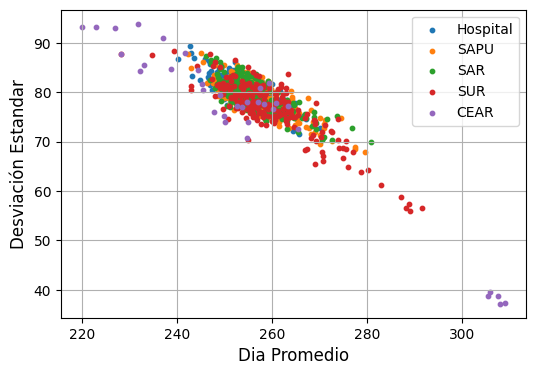

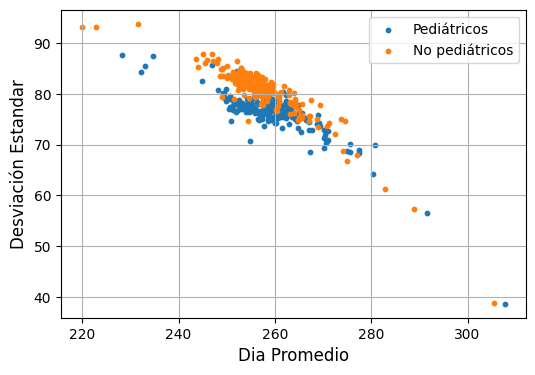

In [7]:
#Medidas de forma de cada uno de los perfiles 
groups = df_output[["year",'CodigoDependencia','establecimiento',"grupo_etario"]].drop_duplicates()
df_aux =df_output.copy()

medidas_de_forma_list = []
for (index, year, codigo_dependencia, establecimiento, grupo_edad) in groups.itertuples():
    indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'CodigoDependencia'] == codigo_dependencia) & (df_aux.loc[:,'establecimiento'] == establecimiento) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
    if sum(indicesToKeep)>0:
        df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'].cumsum()
        media = np.sum(df_aux.loc[indicesToKeep, 'atenciones'] * df_aux.loc[indicesToKeep, 'nrodia'])/df_aux.loc[indicesToKeep, 'atenciones'].sum()
        variance =  np.sum(df_aux.loc[indicesToKeep, 'atenciones'] * (df_aux.loc[indicesToKeep, 'nrodia']- media )* (df_aux.loc[indicesToKeep, 'nrodia']- media ))/(df_aux.loc[indicesToKeep, 'atenciones'].sum()-1)
        medidas_de_forma_list.append( (year, codigo_dependencia, establecimiento, grupo_edad,media,np.sqrt(variance)) ) 
df_medidas_de_forma= pd.DataFrame(medidas_de_forma_list,columns = ["year",'CodigoDependencia','establecimiento',"grupo_etario","dia_promedio","std"])

#df_medidas_de_forma

fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1) 
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
ax.set_xlabel('Dia Promedio', fontsize = 12)
ax.set_ylabel('Desviación Estandar', fontsize = 12)

for target in lista_establecimientos:
    indicesToKeep = df_medidas_de_forma['establecimiento'] == target
    ax.scatter(df_medidas_de_forma.loc[indicesToKeep, 'dia_promedio']
               , df_medidas_de_forma.loc[indicesToKeep, 'std']
               , s = 10)
ax.grid()
plt.legend(lista_establecimientos)



fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1) 
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
ax.set_xlabel('Dia Promedio', fontsize = 12)
ax.set_ylabel('Desviación Estandar', fontsize = 12)
for group_indices in [[0,1,2], [3,4]]:
    targets = []
    for ind in group_indices:
        if len(targets) == 0:
            indicesToKeep = (df_medidas_de_forma[["grupo_etario"]]==grupos_etarios[ind]).values.ravel()
        else:
            indicesToKeep = indicesToKeep | (df_medidas_de_forma[["grupo_etario"]]==grupos_etarios[ind]).values.ravel()
    ax.scatter(df_medidas_de_forma.loc[indicesToKeep, 'dia_promedio']
               , df_medidas_de_forma.loc[indicesToKeep, 'std']
               , s = 10)
ax.grid()
plt.legend(["Pediátricos", "No pediátricos"])

In [8]:
#the cumulative sum is taken on each of the classes, 

groups = df_output[["year",'CodigoDependencia','establecimiento',"grupo_etario"]].drop_duplicates()
df_aux =df_output.copy()
for (index, year, codigo_dependencia, establecimiento, grupo_edad) in groups.itertuples():
    indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'CodigoDependencia'] == codigo_dependencia) & (df_aux.loc[:,'establecimiento'] == establecimiento) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
    if sum(indicesToKeep)>0:
        if USE_CUMSUM:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'].cumsum()
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / max(df_aux.loc[indicesToKeep, 'atenciones'])
        else:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / sum(df_aux.loc[indicesToKeep, 'atenciones'])
df3 = df_aux.pivot(index=['year','CodigoDependencia','establecimiento','grupo_etario'],columns= 'nrodia',values='atenciones').reset_index()
df3_copy = df3.copy()

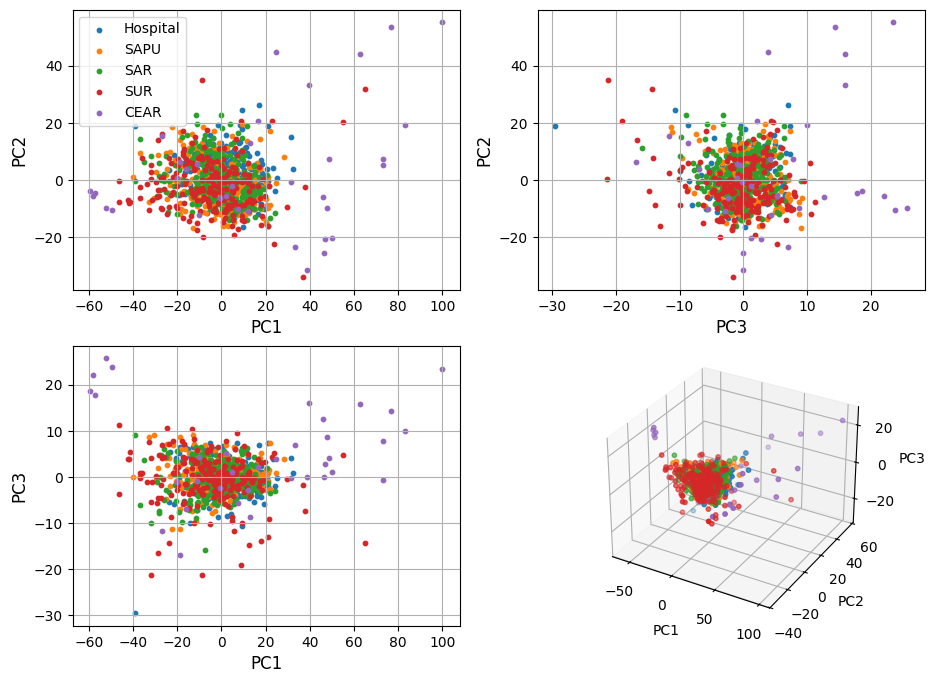

In [9]:
df3 = df3_copy

#indica cuales son los grupos etarios que vamos a unir para la clasificacion
row_filter = []
for ind in filtro_grupo_etarios:
    if len(row_filter) == 0:
        row_filter = (df3.loc[:,"grupo_etario"]==grupos_etarios[ind])
    else:
        row_filter = row_filter | (df3.loc[:,"grupo_etario"]==grupos_etarios[ind])

df3 = df3.loc[row_filter,:].reset_index(drop=True)

# Separating out the features
x_original = df3.loc[:, [k+1 for k in range(periodo)]].values

# Separating out the target
y = df3.loc[:,['establecimiento']].values

#Standardizing the features
scaler = StandardScaler().fit(x_original)
x = scaler.transform(x_original)

pca = PCA(n_components=4)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3','PC4'])
finalDf = pd.concat([principalDf, df3[['year','CodigoDependencia','establecimiento','grupo_etario']]], axis = 1)


fig = plt.figure(figsize = (11,8))
ax = fig.add_subplot(2,2,1) 

ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)

for target in lista_establecimientos:
    indicesToKeep = finalDf['establecimiento'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 10)
ax.grid()
ax.legend(lista_establecimientos_legend)
    
ax = fig.add_subplot(2,2,2) 
ax.set_xlabel('PC3', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in lista_establecimientos:
    indicesToKeep = finalDf['establecimiento'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC3']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 10)
ax.grid()
    
ax = fig.add_subplot(2,2,3) 
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC3', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in lista_establecimientos:
    indicesToKeep = finalDf['establecimiento'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC3']
               , s = 10)
ax.grid()

#3D PLot of the principal componentes
ax = fig.add_subplot(2,2,4,projection='3d')

ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in lista_establecimientos:
    indicesToKeep = finalDf['establecimiento'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , finalDf.loc[indicesToKeep, 'PC3']
               , s = 10)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [10]:
np.sum(np.isnan(x))

np.int64(0)

In [11]:
#Short report of the performance of the PCA analysis
print("Percentange of the variance explained by each principal component")
print(pca.explained_variance_ratio_)

Percentange of the variance explained by each principal component
[0.63046141 0.20350046 0.05216153 0.03586035]


In [12]:
#test for a good group in the classification
# here we test the different groupings to check if there 
# are others that make sense, since we test for binary classification 
#and we only have 5 classes it makes sense to consider the groupings
# (1), (2), (3), (4), (5), (1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5),(3,4),(3,5),(4,5)
#those can be presetned in an array and they describe all the possibilities for binary classification


# Declare the group we are trying to separate
maxiter = 1000
resultados= np.zeros([maxiter,len(lista_establecimientos),len(lista_establecimientos)])
resultados_dic = {}
for iter in range(maxiter):
    for group_indices in lista_agrupaciones:
        targets = []
        for ind in group_indices:
            if len(targets) == 0:
                targets = (finalDf[["establecimiento"]]==lista_establecimientos[ind]).values.ravel()
            else:
                targets = targets | (finalDf[["establecimiento"]]==lista_establecimientos[ind]).values.ravel()
    
        X, y = finalDf[["PC1","PC2","PC3"]].values , targets 
        
        # Split the dataset into a training and a testing set(20 percent)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
        
        # Standarize the features
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # create the linear model SGDclassifier
        linear_clf = SGDClassifier(loss="hinge", alpha=0.000001, max_iter=1000)
        
        # Train the classifier using fit() function
        linear_clf.fit(X_train, y_train)
    
        # Evaluate the result 
        y_train_pred = linear_clf.predict(X_train)
        #precision_clasificador  = f1_score(y_train, y_train_pred)
        precision_clasificador = metrics.balanced_accuracy_score(y_train, y_train_pred)
        #precision_clasificador = metrics.accuracy_score(y_train, y_train_pred)
        if len(group_indices)==1:
            resultados[iter, group_indices[0],group_indices[0]] = precision_clasificador
        elif len(group_indices)==2:
            resultados[iter, group_indices[0],group_indices[1]] = precision_clasificador
            resultados[iter, group_indices[1],group_indices[0]] = resultados[iter,group_indices[0],group_indices[1]]
        
        if tuple(group_indices) in resultados_dic.keys():
            resultados_dic[tuple(group_indices)].append(precision_clasificador)
        else:
            resultados_dic[tuple(group_indices)]= [precision_clasificador]
        
summary_resultados = {key:np.mean(value) for key, value in resultados_dic.items()}
summary_resultados

summary_resultados_sorted = sorted(summary_resultados.items(), key=lambda x:-x[1])
summary_resultados_con_etiquetas = []
for row in summary_resultados_sorted:
    key = tuple(lista_establecimientos[ind] for ind in row[0])
    summary_resultados_con_etiquetas.append([key, row[1]])
pd.DataFrame(summary_resultados_con_etiquetas,columns=["Agrupación","Precisión"])




,Agrupación,Precisión
0,"(CEAR,)",0.694875
1,"(Hospital, CEAR)",0.539822
2,"(SUR,)",0.536169
3,"(SUR, CEAR)",0.532480
4,"(SAPU, SUR)",0.529863
5,"(SAR, SUR)",0.524037
6,"(Hospital, SAR)",0.516494
7,"(SAPU, CEAR)",0.515009
8,"(SAPU, SAR)",0.508652
9,"(SAR, CEAR)",0.507627


In [13]:
pd.DataFrame(resultados.mean(0),columns=lista_establecimientos, index = lista_establecimientos)

,Hospital,SAPU,SAR,SUR,CEAR
Hospital,0.503862,0.504678,0.516494,0.499819,0.539822
SAPU,0.504678,0.502750,0.508652,0.529863,0.515009
SAR,0.516494,0.508652,0.501587,0.524037,0.507627
SUR,0.499819,0.529863,0.524037,0.536169,0.532480
CEAR,0.539822,0.515009,0.507627,0.532480,0.694875
